plt.plot(history_sdg.history['accuracy'])
plt.plot(history_sdg.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')

plt.legend(['train', 'test'], loc = 'upper left')

plt.show()### Import Required Libraries

In [1]:
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
import keras

import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional, RepeatVector, TimeDistributed
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline
#pd.set_option('display.max_colwidth', 200)

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


### Read Data

Se va a trabajar con un dataset de texto con pares de oraciones y frases en inglés y español.

A continuación se define la función usada para leer el texto:

In [2]:
# function to read raw text file
def read_text(filename):
    # open the file
    file = open(filename, mode='rt', encoding='utf-8')
    # read all text
    text = file.read()
    file.close()
    return text

La función que nos permitirá separar el texto en pares de oraciones es la siguiente:

In [3]:
# split a text into sentences
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

En http://www.manythings.org/anki/ se dispone de diferentes datasets de texto con traducciones de diferentes idiomas a inglés. En este caso, como ya se ha indicado, se ha descargado el fichero que contiene traducciones en español.

In [4]:
data = read_text("./spa-eng/spa.txt")
spa_eng = to_lines(data)

In [5]:
spa_eng[0:5]

[['Go.',
  'Ve.',
  'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986655 (cueyayotl)'],
 ['Go.',
  'Vete.',
  'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986656 (cueyayotl)'],
 ['Go.',
  'Vaya.',
  'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986657 (cueyayotl)'],
 ['Go.',
  'Váyase.',
  'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #6586271 (arh)'],
 ['Hi.',
  'Hola.',
  'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #431975 (Leono)']]

El archivo que se acaba de cargar contiene información irrelevante. Las frases y oraciones con las que se van a trabajar se encuentran únicamente en los dos primeros elementos de cada línea, de modo que nos quedamos úncamente con ellos.

In [6]:
spa_eng = [item[0:2] for item in spa_eng]
spa_eng = array(spa_eng)

In [7]:
spa_eng[0:5]

array([['Go.', 'Ve.'],
       ['Go.', 'Vete.'],
       ['Go.', 'Vaya.'],
       ['Go.', 'Váyase.'],
       ['Hi.', 'Hola.']], dtype='<U332')

In [8]:
len(spa_eng)

122936

El fichero contiene más de 120.000 pares de oraciones. En algunas ocasiones, para reducir el tiempo de computación cuando se entrene el modelo, se utiliza una muestra reducida del dataset.

In [9]:
#spa_eng = spa_eng[:50000,:]

### Text Pre-Processing

#### Text Cleaning

In [10]:
spa_eng

array([['Go.', 'Ve.'],
       ['Go.', 'Vete.'],
       ['Go.', 'Vaya.'],
       ...,
       ['Since there are usually multiple websites on any given topic, I usually just click the back button when I arrive on any webpage that has pop-up advertising. I just go to the next page found by Google and hope for something less irritating.',
        'Como suele haber varias páginas web sobre cualquier tema, normalmente sólo le doy al botón de retroceso cuando entro en una página web que tiene anuncios en ventanas emergentes. Simplemente voy a la siguiente página encontrada por Google y espero encontrar algo menos irritante.'],
       ['If you want to sound like a native speaker, you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo.',
        'Si quieres sonar como un hablante nativo, debes estar dispuesto a practicar diciendo la misma frase una y

Continuando con la preparación del dato, se van a eliminar los caracteres no alfanuméricos así como las mayúsculas.

In [11]:
# Remove punctuation
spa_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in spa_eng[:,0]]
spa_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in spa_eng[:,1]]

In [12]:
# convert to lowercase
for i in range(len(spa_eng)):
    spa_eng[i,0] = spa_eng[i,0].lower()
    
    spa_eng[i,1] = spa_eng[i,1].lower()

In [13]:
spa_eng

array([['go', 've'],
       ['go', 'vete'],
       ['go', 'vaya'],
       ...,
       ['since there are usually multiple websites on any given topic i usually just click the back button when i arrive on any webpage that has popup advertising i just go to the next page found by google and hope for something less irritating',
        'como suele haber varias páginas web sobre cualquier tema normalmente sólo le doy al botón de retroceso cuando entro en una página web que tiene anuncios en ventanas emergentes simplemente voy a la siguiente página encontrada por google y espero encontrar algo menos irritante'],
       ['if you want to sound like a native speaker you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo',
        'si quieres sonar como un hablante nativo debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la 

#### Text to Sequence Conversion

Para terminar de preparar los datos que se ingestarán en el modelo se van a codificar las frases en vectores con la misma longitud.

In [14]:
# empty lists
eng_l = []
spa_l = []

# populate the lists with sentence lengths
for i in spa_eng[:,0]:
    eng_l.append(len(i.split()))

for i in spa_eng[:,1]:
    spa_l.append(len(i.split()))

In [15]:
length_df = pd.DataFrame({'eng':eng_l, 'spa':spa_l})
print(length_df)

        eng  spa
0         1    1
1         1    1
2         1    1
3         1    1
4         1    1
...     ...  ...
122931   34   42
122932   34   35
122933   43   44
122934   47   49
122935   47   53

[122936 rows x 2 columns]


No todas las frases presentan el mismo tamaño por lo que, posteriormente, será conveniente utilizar padding con el objetivo de homogeneizar la longitud de los vectores de enteros con los que se va a trabajar.

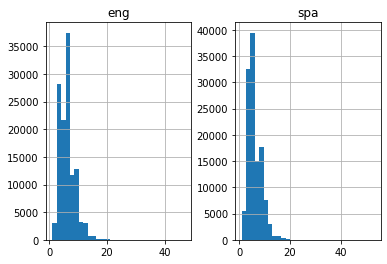

In [16]:
length_df.hist(bins = 30)
plt.show()

Antes de pasar por el encoder, se van a tokenizar las frases en palabras. Esto nos va a permitir conocer con más detalle el texto con el que se está trabajando: cuáles son las distintas palabras que aparecen, cuáles son las palabras más y menos frecuentes, etc.

In [17]:
# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [18]:
# prepare english tokenizer
eng_tokenizer = tokenization(spa_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 13731


In [19]:
spa_tokenizer = tokenization(spa_eng[:, 1])
spa_vocab_size = len(spa_tokenizer.word_index) + 1

print('Spanish Vocabulary Size: %d' % spa_vocab_size)

Spanish Vocabulary Size: 27431


Las palabras más repetidas en inglés son:

In [20]:
from itertools import islice

list(islice(eng_tokenizer.word_counts.items(), 10))

[('go', 2936),
 ('hi', 20),
 ('run', 219),
 ('who', 1453),
 ('wow', 11),
 ('fire', 239),
 ('help', 1347),
 ('jump', 28),
 ('stop', 535),
 ('wait', 413)]

Las palabras más repetidas en español son:

In [21]:
list(islice(spa_tokenizer.word_counts.items(), 10))

[('ve', 229),
 ('vete', 39),
 ('vaya', 170),
 ('váyase', 8),
 ('hola', 22),
 ('¡corre', 1),
 ('¡corran', 1),
 ('¡corra', 1),
 ('¡corred', 1),
 ('corred', 3)]

A continuación se define la función que se va a utilizar para codificar las frases en vectores de enteros donde se ha incluído el padding antes mencionado.

In [22]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    print(seq)
    print(len(seq))
    return seq

### Model Building

Antes de comenzar con la construcción del modelo, se va a realizar la división de la muestra de training (80%) y test (20%)

In [23]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(spa_eng, test_size=0.2, random_state = 12)

A continuación, haciendo uso de la función encode_sequences se van a codificar las oraciones tanto de la muestra de training como de test estableciendo como entrada las frases en español y como objetivo la traducción a inglés.

Puesto que la función encode_sequences requiere de la longitud de los vectores objetivo, se va a calcular la máxima longitud de las oraciones de entrada para cada uno de los dos idiomas.

In [24]:
spa_length = max(length_df.spa)
eng_length = max(length_df.eng)

In [25]:
# prepare training data
trainX = encode_sequences(spa_tokenizer, spa_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

[[   99    64    29 ...     0     0     0]
 [    6  1153 15094 ...     0     0     0]
 [    4   114  4282 ...     0     0     0]
 ...
 [   60   316  2401 ...     0     0     0]
 [    4   275   810 ...     0     0     0]
 [   19   119  1840 ...     0     0     0]]
98348
[[  44   22   86 ...    0    0    0]
 [8196 1181    7 ...    0    0    0]
 [   2   56   31 ...    0    0    0]
 ...
 [  74  470  836 ...    0    0    0]
 [   2  219   68 ...    0    0    0]
 [  17  156 1081 ...    0    0    0]]
98348


In [26]:
print(trainX.shape)
print(trainY.shape)

(98348, 53)
(98348, 47)


In [27]:
# prepare validation data
testX = encode_sequences(spa_tokenizer, spa_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

[[  22   55 4701 ...    0    0    0]
 [  11  164  244 ...    0    0    0]
 [   9  201    2 ...    0    0    0]
 ...
 [  13  125   15 ...    0    0    0]
 [  23  278   14 ...    0    0    0]
 [ 530  932  108 ...    0    0    0]]
24588
[[  21   42 3163 ...    0    0    0]
 [ 161   35    3 ...    0    0    0]
 [   8    7  224 ...    0    0    0]
 ...
 [   8   54    6 ...    0    0    0]
 [  21  150  532 ...    0    0    0]
 [   2  291    2 ...    0    0    0]]
24588


In [28]:
print(testX.shape)
print(testY.shape)

(24588, 53)
(24588, 47)


A continuación se define la arquitectura del modelo: 

In [38]:
#batch_size = 512

model = Sequential()
model.add(Embedding(spa_vocab_size, batch_size, input_length = spa_length, mask_zero = True))
model.add(LSTM(batch_size))
model.add(RepeatVector(eng_length))    
model.add(LSTM(batch_size, return_sequences = True))
model.add(Dense(eng_vocab_size, activation = 'softmax'))


model.compile(optimizer = 'adam', 
              loss = 'sparse_categorical_crossentropy',
                        metrics=['accuracy'])

eng_vocab_sizeDetails about the RepeatVector :  https://campus.datacamp.com/courses/machine-translation-in-python/implementing-an-encoder-decoder-model-with-keras?ex=6

Entrenando el modelo: con checkpoint y earlystoppin:

In [39]:
filename = 'best_model.h5'
checkpoint = ModelCheckpoint(filename, 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only = True, 
                             mode= 'auto')

es = EarlyStopping(monitor = 'val_accuracy', 
                   mode = 'auto', 
                   verbose = 1, 
                   patience = 5)

from sklearn.model_selection import train_test_split

# GENERAMOS EL SPLIT DATA
x_train, x_valid, y_train, y_valid = train_test_split(trainX, trainY,test_size=0.2,shuffle=False)

In [42]:
### CALLBACK DE TENSORBOARD
import datetime
logdir = os.path.join("logs_NLP", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

tensorboard_callback = tf.keras.callbacks.TensorBoard(
    logdir, histogram_freq=0,
    write_graph=True, write_grads=False,
    write_images=False, embeddings_freq=0,
    embeddings_layer_names=None, embeddings_metadata=None,
    embeddings_data=None, update_freq='epoch'
)

In [41]:
history = model.fit(x_train, y_train.reshape(y_train.shape[0], y_train.shape[1], 1), 
          epochs = 10, batch_size = 64, 
          validation_data=(x_valid, y_valid.reshape(y_valid.shape[0], y_valid.shape[1], 1)),
          callbacks=[tensorboard_callback,checkpoint, es], verbose=1)

Epoch 1/30
1230/1230 [==============================] - 2058s 2s/step - loss: 1.3196 - accuracy: 0.8618 - val_loss: 0.8588 - val_accuracy: 0.8752

Epoch 00001: val_accuracy improved from -inf to 0.87521, saving model to best_model.h5
Epoch 2/30
1155/1230 [===========================>..] - ETA: 1:50 - loss: 0.8320 - accuracy: 0.8773

KeyboardInterrupt: 

Se representan a continuación los resultados obtenidos:

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')

plt.legend(['train', 'test'], loc = 'best')

plt.show()

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')

plt.legend(['train', 'test'], loc = 'best')

plt.show()

### Make Predictions

Por último, haciendo uso del modelo que hemos guardado es posible observar las traducciones propuestas por el modelo.

In [ ]:
model = load_model('best_model.h5')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

In [ ]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [ ]:
# convert predictions into text (English)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

In [ ]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [ ]:
pd.set_option('display.max_colwidth', 200)

In [ ]:
pred_df.head(15)

In [ ]:
pred_df.tail(15)

In [ ]:
pred_df.tail(15)

In [ ]:
pred_df.sample(15)